In [1]:
import sys
sys.path.append("code")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spiceypy as spice

In [3]:
from plotting import format_plot, save_plot
from spice_tools import as_et, as_utc

# Equivalent cannonball

From Smith 2008:

In [4]:
data = pd.DataFrame.from_records([
    ("+x", 0.29, 0.22, 2.82),
    ("-x", 0.39, 0.19, 2.82),
    ("+y", 0.32, 0.23, 3.69),
    ("-y", 0.32, 0.18, 3.69),
    ("+z", 0.32, 0.18, 5.14),
    ("-z", 0.54, 0.18, 5.14),
    ("+sa", 0.05, 0.05, 11.00),
    ("-sa", 0.05, 0.05, 11.00),
    ("+hga", 0.18, 0.28, 1.00),
    ("-hga", 0.019, 0.0495, 1.00)
], columns=["panel", "Cs", "Cd", "A"], index="panel").convert_dtypes()

data["Ca"] = 1 - data["Cs"] - data["Cd"]
data["exposure_factor"] = [1] * 6 + [2 / np.pi] * 4
data["A_scaled"] = data["A"] * data["exposure_factor"]
data

,Cs,Cd,A,Ca,exposure_factor,A_scaled
panel,,,,,,
+x,0.29,0.22,2.82,0.49,1.00000,2.82
-x,0.39,0.19,2.82,0.42,1.00000,2.82
+y,0.32,0.23,3.69,0.45,1.00000,3.69
-y,0.32,0.18,3.69,0.5,1.00000,3.69
+z,0.32,0.18,5.14,0.5,1.00000,5.14
-z,0.54,0.18,5.14,0.28,1.00000,5.14
+sa,0.05,0.05,11.0,0.9,0.63662,7.002817
-sa,0.05,0.05,11.0,0.9,0.63662,7.002817
+hga,0.18,0.28,1.0,0.54,0.63662,0.63662


Assume that solar array and high-gain antenna are scaled by average visibility if they rotated continuously

In [5]:
areas = data["A_scaled"]
area_body_avg = np.mean([areas["+x"], areas["+y"], areas["+z"]])
area_cannonball = area_body_avg + areas["+sa"] + areas["+hga"]
area_cannonball

11.522770601744309

In [6]:
reflectivity = data["Cs"]  # Total reflectivity
reflectivity_cannonball = np.average(
    reflectivity,
    weights=areas
)
1 + reflectivity_cannonball

1.2469374547257144

# Orientation

/tmp/ipykernel_714701/1456666201.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha="right")


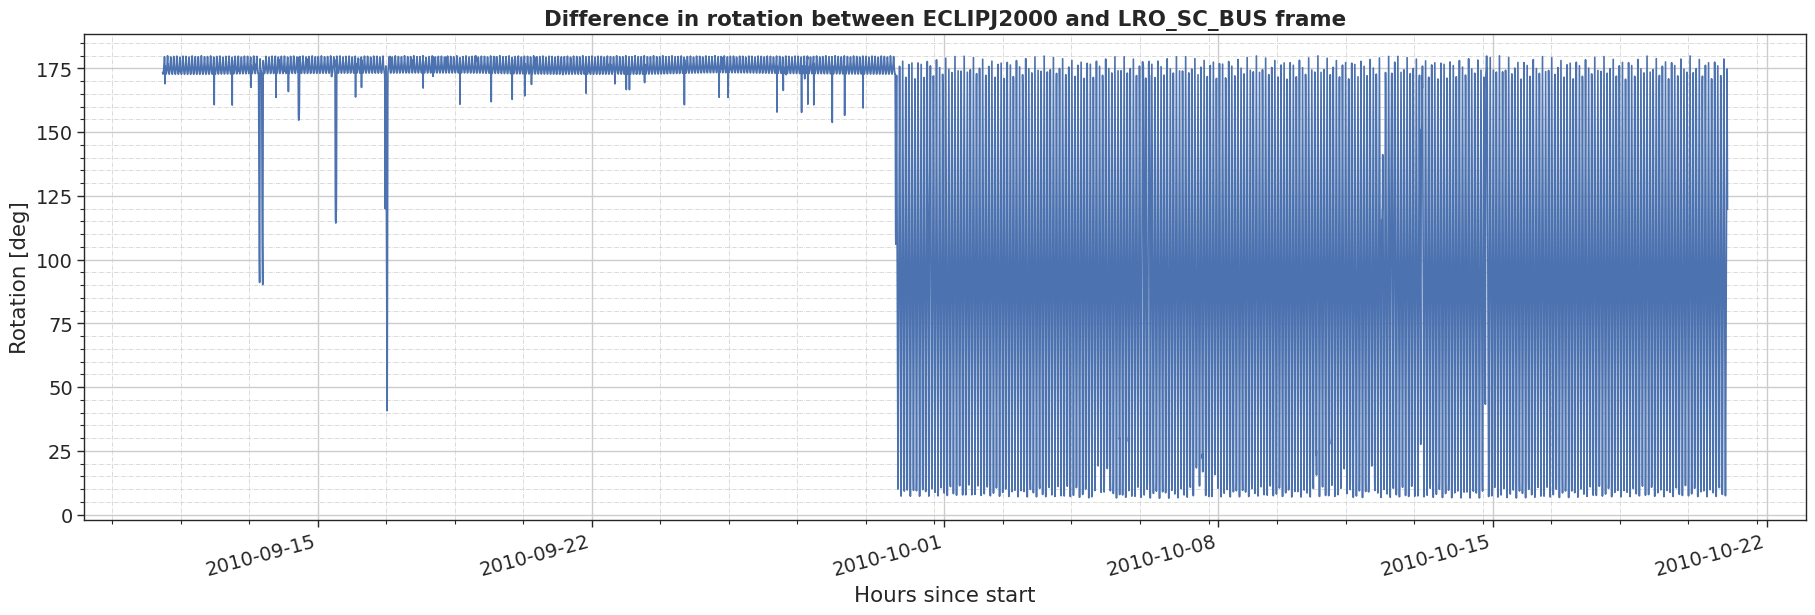

In [11]:
def plot_frame_difference(from_frame: str, to_frame: str):
    def quat_to_deg(q):
        ang_rad = 2 * np.arctan2(np.linalg.norm(q[1:]), q[0])
        return np.degrees(ang_rad)

    fig, ax = plt.subplots(figsize=(18, 6))

    t_start = as_et("2010 SEP 11 01:00:00")
    t_end = as_et("2010 OCT 21 00:00:00")
    # t_start = as_et("2010 SEP 26 06:00:00")
    # t_end = t_start + 32 * 113 * 60
    t = np.linspace(t_start, t_end, 10000)

    plt.plot(
        # (t - t_start) / (3600),
        pd.to_datetime([as_utc(tt) for tt in t]),
        np.vectorize(lambda tt: quat_to_deg(spice.m2q(spice.pxform(from_frame, to_frame, tt))))(t))
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha="right")

    plt.xlabel("Hours since start")
    plt.ylabel("Rotation [deg]")
    plt.title(f"Difference in rotation between {from_frame} and {to_frame} frame")

    format_plot()

# plot_frame_difference("MOON_PA", "LRO_SC_BUS")
plot_frame_difference("ECLIPJ2000", "LRO_SC_BUS")
# plot_frame_difference("IAU_EARTH", "LRO_SC_BUS")